# Building a Convolutional VAE in TensorFlow to draw MNIST characters
The goal of this is to practice with ConvVAE's to translate the learns to Sonic data.

After completing this notebook, the Sonic data will have to be manipulated to work through the same kind of flow.

Source of notebook code: https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

In [1]:
# import dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# define the input and output data
# MNIST images have a dimension of 28*28 pixels with one color channel

tf.reset_default_graph()

batch_size = 64

# inputs are batches of MNIST characters
X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')

# outputs will be reconstructed with the same shape
Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')

# Y_flat is used for computing losses later on
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])

# keep_prob will be used for dropout during training as a means of regularization
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2

# TensorFlow doesn't have a leaky relu function so we make one
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

## Defining the Convolutional Encoder
The inputs are images, so applying convolutional transforms makes sense.

We are creating two vectors within the encoder, the encoder creates objects objects following a Gaussian Distribution:
* A vector of means
* A vector of standard deviations

Later on, the encoder is forced to create values from a Normal Distribution. 

Returned z-values from the encoder are fed to the decoder.

The mean and standard deviations of the distributions will be used later for computing losses.

In [3]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

## Defining the Convolutional Decoder
The decoder reconstructs the data its fed. To do this, a series of transpose convolutions are done.

In [4]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

Bring together the encoder and decoder:

In [5]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

## Computing losses and enforcing a Gaussian latent distribution
Computing the reconstruction loss involves using the squared distance (this could be improved upon).

This loss is combined with the Kullback-Leibler divergence (KL divergence), which makes sure our latent values will be sampled from a normal distribution.

In [6]:
unreshaped = tf.reshape(dec, [-1, 28*28])

# Calculate the loss using squared difference between decoder reshaped output and Y_flat
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)

# KL loss
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)

# Combine the losses together to ensure latent values are sampled from a normal distribution
loss = tf.reduce_mean(img_loss + latent_loss)

# define the optimizer, in this case, we're using Adam with a learning_rate of 0.0005 and trying to minimize `loss`
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)

# create TensorFlow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training the network on the MNIST datset
Whilst our VAE is training, we'll take a look at the reconstructions every 500 steps. 

After 2000 batches, most reconstructions should look recognisable.

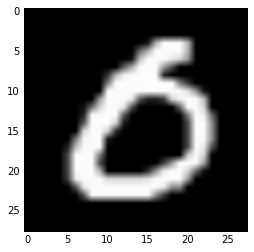

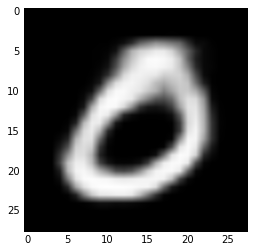

(0, 30.956602, 21.778093, 9.1785088)


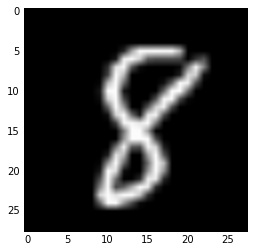

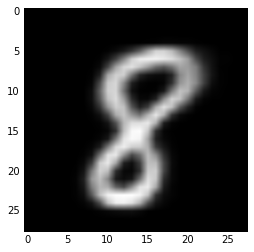

(500, 31.266098, 21.027977, 10.23812)


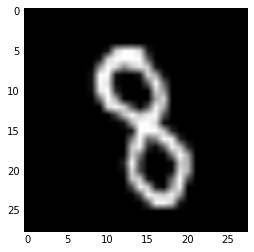

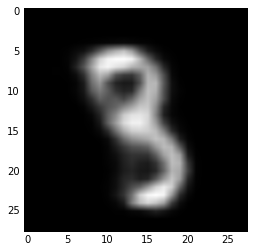

(1000, 30.954201, 20.817318, 10.136881)


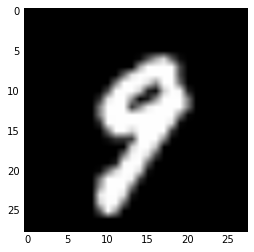

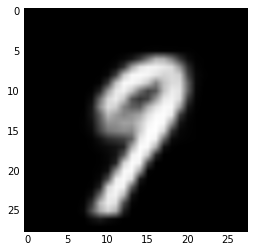

(1500, 28.18644, 18.316048, 9.8703899)


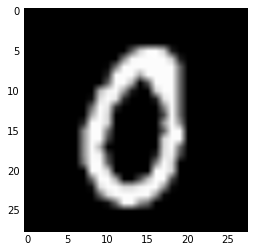

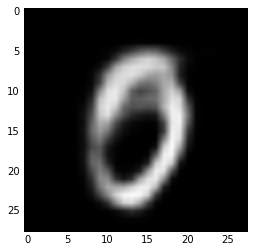

(2000, 28.160442, 18.300354, 9.8600883)


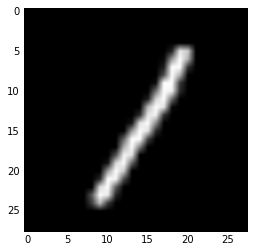

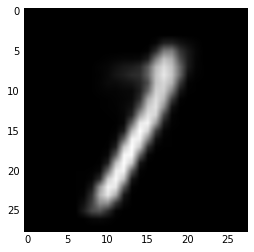

(2500, 28.086538, 17.967541, 10.118999)


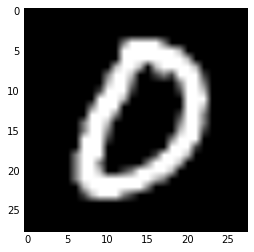

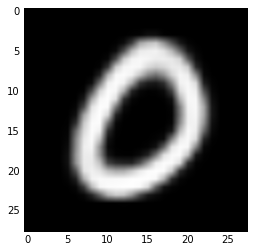

(3000, 29.616329, 19.11363, 10.502698)


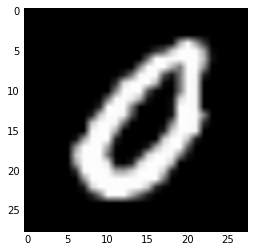

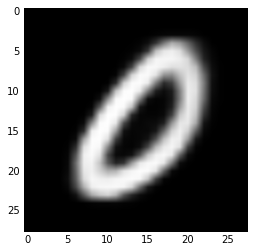

(3500, 28.692162, 18.683422, 10.008741)


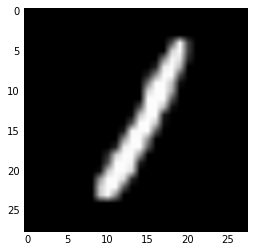

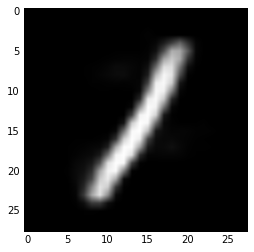

(4000, 30.701485, 20.771458, 9.930027)


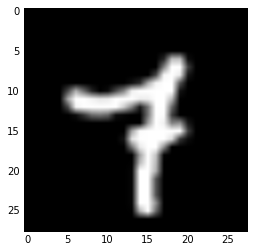

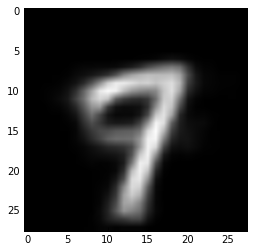

(4500, 27.414162, 17.669617, 9.744544)


In [ ]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    
    if not i % 500:
        ls, d, i_ls, d_ls, mu, sigma = sess.run([loss, dec, img_loss, latent_loss, mn, sd], 
                                                feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

# Generating new data
With our model we can create new characters.

We can sample values from a unit a normal distribution and feed them to the decoder.

In [ ]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis=('off')
    plt.imshow(img, cmap='gray')